<a href="https://colab.research.google.com/github/Nyillu/Algorithms_Big_Data_Zavadskaya/blob/main/feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature engineering

This notebook presents work on the features of our data. The work was carried out according to the following plan:

- [ ] drop incomplete features
- [ ] drop features with high correlation
- [ ] drop features with (near-)zero variance


This code is made to be run locally within current repository. If you work in Google Colab, adjust the path to the `data_with_descriptors.csv` file accordingly and install the libraries provided in the *requirements*.

The **result of working** in this notepad is the `data_clean.csv` file.


# Requirements

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Big data/data_with_descriptors.csv', low_memory=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1840 entries, mol_id to mZagreb2
dtypes: bool(2), float64(970), int64(428), object(440)
memory usage: 280.5+ MB


# Drop incomplete features

While dividing the dataset into categorical and numerical features, it became clear that many descriptors were unloaded with **errors.**

Here the replacement of incorrectly unloaded values with NaNs is presented. As a result, all features are converted to numbers.

Columns with more than $1000$ NaN ($5\%$ of the dataframe) were also removed.

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns

df_num = df[numeric_columns]
df_cat = df[categorical_columns]
df_bool = df[boolean_columns]

In [ ]:
print ('Количество колонок с числовыми признаками:', len(numeric_columns))
print ('Количество колонок с категориальными признаками:', len(categorical_columns))
print ('Количество колонок с булевыми значениями:', len(boolean_columns))

Количество колонок с числовыми признаками: 1398
Количество колонок с категориальными признаками: 440
Количество колонок с булевыми значениями: 2


In [ ]:
df_cat

,mol_id,smiles,AATS4dv,AATS5dv,AATS6dv,AATS7dv,AATS8dv,AATS4d,AATS5d,AATS6d,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,gdb_89835,OC1CC2(CC2)CC1=O,0.9777777777777777,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.5777777777777777,1.125,1.0,...,float division by zero (MDEC-44),0.33333333333333337,float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
1,gdb_36873,C1CC1NC2=NCCO2,2.5454545454545454,0.7272727272727273,0.0,0.0,invalid value encountered in double_scalars (A...,2.727272727272727,2.3636363636363638,1.8,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),0.4999999999999999,float division by zero (MDEN-23),float division by zero (MDEN-33)
2,gdb_19320,C#CC12CC1C1OC21,1.588235294117647,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.6470588235294117,1.4285714285714286,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
3,gdb_96404,CC1OCOCC1C#C,1.2926829268292683,0.20689655172413793,0.0,0.0,invalid value encountered in double_scalars (A...,1.6341463414634145,1.2758620689655173,1.1666666666666667,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),0.4999999999999999,float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
4,gdb_44243,N=C1OC2C1CCC2=O,2.0,3.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.6666666666666667,1.375,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),0.33333333333333337,float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,gdb_67709,CC12C3COC1OCC23,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.488888888888889,1.0,invalid value encountered in double_scalars (A...,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),0.4999999999999999,float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
19996,gdb_23674,c1c(ncnc1F)F,17.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.5714285714285714,1.0,invalid value encountered in double_scalars (A...,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),0.4999999999999999,float division by zero (MDEN-23),float division by zero (MDEN-33)
19997,gdb_45091,O=C1CC2NC2C2CN12,1.3548387096774193,0.0,invalid value encountere

In [ ]:
# Replace errors in unloading descriptors with NaN values
for col in categorical_columns:
    df[col] = df[col].replace(to_replace=[r'^invalid value.*', r'^float division.*', r'^max().*', r'^min().*', r'^module.*' ],
                              value=np.nan, regex=True).infer_objects()

In [ ]:
numeric_like_columns = []
for col in df.columns:
    try:
        # Try to convert the values in the column into numbers
        pd.to_numeric(df[col])
        # If successful, add the column to the list of numeric_like_columns
        numeric_like_columns.append(col)
    except ValueError:
        # If the conversion causes an error, it means that the column does not contain only numbers
        pass

# Changing data type to float
df[numeric_like_columns] = df[numeric_like_columns].astype(float)

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print ('Количество колонок с числовыми признаками:', len(numeric_columns))
print ('Количество колонок с категориальными признаками:', len(categorical_columns))
print ('Количество колонок с булевыми значениями:', len(boolean_columns))

Количество колонок с числовыми признаками: 1837
Количество колонок с категориальными признаками: 3
Количество колонок с булевыми значениями: 0


In [ ]:
# Delete columns with the number of zero values greater than 1000 (5% of the dataset)
THRESHOLD = 1000
df.dropna(thresh=len(df) - THRESHOLD, axis=1, inplace=True)

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print ('Количество колонок с числовыми признаками:', len(numeric_columns))
print ('Количество колонок с категориальными признаками:', len(categorical_columns))
print ('Количество колонок с булевыми значениями:', len(boolean_columns))

Количество колонок с числовыми признаками: 1501
Количество колонок с категориальными признаками: 3
Количество колонок с булевыми значениями: 0


In [ ]:
categorical_columns

Index(['mol_id', 'smiles', 'HybRatio'], dtype='object')

In [ ]:
df.HybRatio.value_counts()

1.0                                            7133
0.8333333333333334                             2071
0.8                                            1261
0.8571428571428571                             1199
0.5                                            1012
0.75                                            967
0.0                                             954
0.6666666666666666                              880
0.6                                             783
0.7142857142857143                              531
0.3333333333333333                              505
0.25                                            479
0.4                                             477
0.2                                             444
0.5714285714285714                              393
0.16666666666666666                             180
0.875                                           180
0.42857142857142855                             157
0.7777777777777778                              140
0.625       

In [ ]:
# Replace 'there are no sp3 and sp2 carbons' in unloading descriptors with NaN value
for col in categorical_columns:
    df[col] = df[col].replace(to_replace=[r'^there.*'],
                              value=np.nan, regex=True).infer_objects()

In [ ]:
pd.to_numeric(df['HybRatio'])

0        0.857143
1        0.833333
2        1.000000
3        1.000000
4        0.666667
           ...   
19995    1.000000
19996    0.000000
19997    0.833333
19998    1.000000
19999    1.000000
Name: HybRatio, Length: 20000, dtype: float64

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print ('Количество колонок с числовыми признаками:', len(numeric_columns))
print ('Количество колонок с категориальными признаками:', len(categorical_columns))
print ('Количество колонок с булевыми значениями:', len(boolean_columns))

Количество колонок с числовыми признаками: 1502
Количество колонок с категориальными признаками: 2
Количество колонок с булевыми значениями: 0


## Dealing with NaNs

Since the missing values were mainly for the **same rows**, it was decided to **remove** them. The only missing value in the column `'HybRatio'` was filled by the mean.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1504 entries, mol_id to mZagreb2
dtypes: float64(1502), object(2)
memory usage: 229.5+ MB


In [ ]:
null_counts = df.isnull().sum()
nulls = null_counts[null_counts > 0]

In [ ]:
nulls

AATS4dv      3
AATS5dv     71
AATS4d       3
AATS5d      71
AATS4s       3
          ... 
AXp-5d     345
AXp-3dv      2
AXp-4dv     23
AXp-5dv    345
Kier3        2
Length: 102, dtype: int64

In [ ]:
df_without_NaN = df.dropna(subset=['AXp-5d', 'AATS5dv'])

In [ ]:
len(df_without_NaN)

19616

In [ ]:
null_counts = df_without_NaN.isnull().sum()
nulls = null_counts[null_counts > 0]
nulls

HybRatio    1
dtype: int64

In [ ]:
mean_value = df_without_NaN['HybRatio'].mean()
df_without_NaN.loc[:, 'HybRatio'] = df_without_NaN['HybRatio'].fillna(mean_value)

<ipython-input-58-2209788043a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_NaN.loc[:, 'HybRatio'] = df_without_NaN['HybRatio'].fillna(mean_value)


In [ ]:
null_counts = df_without_NaN.isnull().sum()
nulls = null_counts[null_counts > 0]
nulls

Series([], dtype: int64)

In [ ]:
df_without_NaN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19616 entries, 0 to 19999
Columns: 1504 entries, mol_id to mZagreb2
dtypes: float64(1502), object(2)
memory usage: 225.2+ MB


# Drop features with high correlation

Features whose correlation between each other was more than $0{.}75$ were removed.

Before analyzing **target value** `'gap'` as well as the parameters `'homo'` and `'lumo'` that directly correlate with the target value were removed from descriptors.

In [ ]:
df_num = df_without_NaN[numeric_columns].drop(['gap', 'homo', 'lumo'], axis = 1)

In [ ]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1501 entries, A to mZagreb2
dtypes: float64(1501)
memory usage: 229.0 MB


In [ ]:
corr_matrix = df_num.corr().abs()

# Creating a mask for the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Finding indexes of columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Removal highly correlated features
df_after_corr = df_num.drop(columns=to_drop)

print("Количество признаков после удаления коррелирующих:", df_after_corr.shape[1])

Количество признаков после удаления коррелирующих: 461


In [ ]:
len(to_drop)

1038

In [ ]:
df_after_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19616 entries, 0 to 19999
Columns: 461 entries, A to TopoShapeIndex
dtypes: float64(461)
memory usage: 69.1 MB


# Drop features with (near-)zero variance

Since columns with (near-)zero variance are not particularly informative we can remove them. For this we will use `VarianceThreshold`

In [ ]:
from sklearn.feature_selection import VarianceThreshold

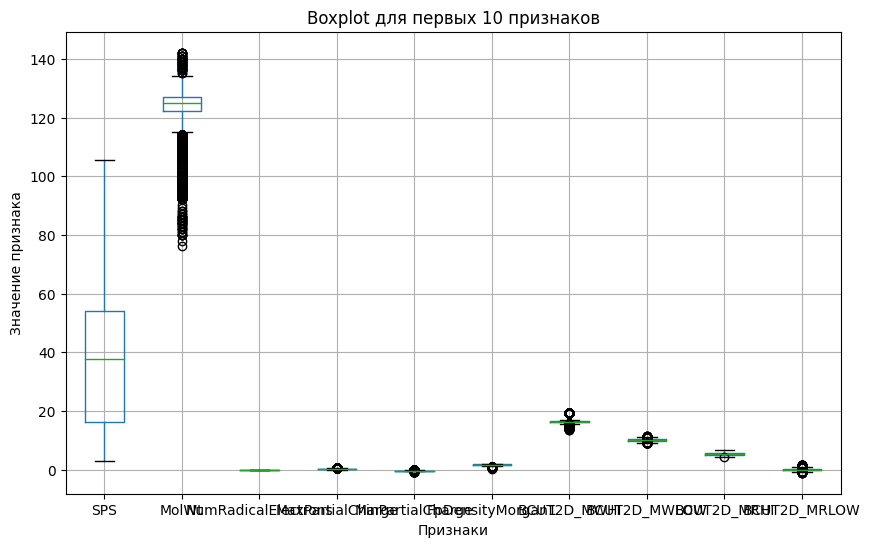

In [ ]:
features_to_plot = df_after_corr.iloc[:, 11:21]

# Creating a boxplot for the selected attributes (not very representative, because features have different dimensions)
plt.figure(figsize=(10, 6))
features_to_plot.boxplot()
plt.title('Boxplot для первых 10 признаков')
plt.ylabel('Значение признака')
plt.xlabel('Признаки')
plt.show()

In [ ]:
THRESHOLD = 0.01

# Creating a VarianceThreshold object
selector = VarianceThreshold(THRESHOLD)

df_clean = df_after_corr.copy()
selector.fit(df_clean)

mask = selector.get_support()

# Filtering: only features that pass the threshold
df_clean = df_clean.loc[:, mask]

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19616 entries, 0 to 19999
Columns: 204 entries, A to TopoShapeIndex
dtypes: float64(204)
memory usage: 30.7 MB


# Save clean data

In [ ]:
data_clean = df_without_NaN[['smiles', 'gap']].merge(df_clean, how='inner', left_index=True, right_index=True)

In [ ]:
data_clean

,smiles,gap,A,B,mu,alpha,u0,cv,MaxAbsEStateIndex,MinAbsEStateIndex,...,n4HRing,n6aRing,n5FRing,n6FRing,n7FRing,n8FRing,n9FRing,GGI4,Radius,TopoShapeIndex
0,OC1CC2(CC2)CC1=O,0.2229,3.19334,1.22630,2.7195,75.40,-423.044181,32.436,10.779699,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,3.0,0.333333
1,C1CC1NC2=NCCO2,0.2788,4.92517,0.92431,1.3423,77.99,-419.210684,31.158,5.142639,0.668380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,3.0,0.666667
2,C#CC12CC1C1OC21,0.2499,4.99590,1.69319,1.4352,68.32,-345.287896,26.347,5.296806,0.268519,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.236111,2.0,1.000000
3,CC1OCOCC1C#C,0.3013,2.07981,1.71184,1.8563,76.89,-422.996522,33.086,5.183657,0.137731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262222,3.0,0.666667
4,N=C1OC2C1CCC2=O,0.2058,3.22781,1.45953,1.8143,69.64,-437.911449,27.818,10.759630,0.150463,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.316111,3.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,CC12C3COC1OCC23,0.3306,2.25194,1.97852,2.7998,73.16,-423.030803,29.065,5.386574,0.159722,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,2.0,0.500000
19996,c1c(ncnc1F)F,0.2447,4.22771,1.81684,0.9724,50.29,-462.771586,20.489,11.776389,0.611111,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.222222,3.0,0.333333
19997,O=C1CC2NC2C2CN12,0.2524,2.47194,2.08198,4.9902,71.97,-417.993679,27.702,10.958750,0.353009,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.236111,3.0,0.333333
19998,CC#CC(O)C1(C)CC1,0.2877,2.63754,0.93810,1.9889,87.48,-387.053735,38.899,9.274583,0.141875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.205000,3.0,0.666667


In [ ]:
data_clean.to_csv('/content/drive/MyDrive/Big data/data_clean.csv', index = False)